Changing feature enginering

In [26]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [27]:
import numpy as np
import pandas as pd
import datetime
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
np.random.seed(4590)

In [28]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max(
            )
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


## I will try to train model with outliers and without and see the differences in results. Outliers might be significant even the number of outliers is small it generates huge rmse error

### reload files if required

In [29]:
df_train = pd.read_csv('C:/Users/user/Documents/Salamat/ELO/train.csv')
df_test = pd.read_csv('C:/Users/user/Documents/Salamat/ELO/test.csv')
df_hist_trans = pd.read_csv('C:/Users/user/Documents/Salamat/ELO/historical_transactions_new.csv')
df_new_merchant_trans = pd.read_csv('C:/Users/user/Documents/Salamat/ELO/new_merchant_transactions_new.csv')

df_train=reduce_mem_usage(df_train)
df_test=reduce_mem_usage(df_test)
df_hist_trans=reduce_mem_usage(df_hist_trans)
df_new_merchant_trans=reduce_mem_usage(df_new_merchant_trans)


Mem. usage decreased to  4.04 Mb (56.2% reduction)
Mem. usage decreased to  2.24 Mb (52.5% reduction)
Mem. usage decreased to 1749.11 Mb (43.7% reduction)
Mem. usage decreased to 121.69 Mb (45.8% reduction)


In [30]:
train_month_lag_0=pd.read_csv('C:/Users/user/Documents/Salamat/ELO/train_month_lag_0.csv',header=None,squeeze=True,parse_dates=[0])
test_month_lag_0=pd.read_csv('C:/Users/user/Documents/Salamat/ELO/test_month_lag_0.csv',header=None,squeeze=True,parse_dates=[0])
hist_lag_0=pd.read_csv('C:/Users/user/Documents/Salamat/ELO/hist_month_lag_0.csv',header=None,squeeze=True,parse_dates=[0])
new_mech_lag_0=pd.read_csv('C:/Users/user/Documents/Salamat/ELO/new_mech_month_lag_0.csv',header=None,squeeze=True,parse_dates=[0])

### Let's check number of outliers in in training data, and respective percentage

In [31]:
print('unique values of outliers are same:')
print(df_train[df_train.target<-20].target.unique())

unique values of outliers are same:
[-33.21875]


In [32]:
print('number of outliers are same:')
print(df_train[df_train.target<-20].target.count())
print('Percentage of outliers are same in train data:')
print(len(df_train[df_train.target<-20])/len(df_train)*100)

number of outliers are same:
2207
Percentage of outliers are same in train data:
1.0930233709890698


### let's try with outlier. 

In [33]:
def get_new_columns(name,aggs):
    return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

I we can take weekofyear,day of week, weekend as extra parameter which I didn't. I am not sure if month diff is correct. Still confused about this issue

In [34]:
for df in [df_hist_trans,df_new_merchant_trans]:
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['year'] = df['purchase_date'].dt.year
    df['weekofyear'] = df['purchase_date'].dt.weekofyear
    df['month'] = df['purchase_date'].dt.month
    df['dayofweek'] = df['purchase_date'].dt.dayofweek
    df['weekend'] = (df.purchase_date.dt.weekday >=5).astype(int)
    df['hour'] = df['purchase_date'].dt.hour
    df['authorized_flag'] = df['authorized_flag'].map({'Y':1, 'N':0})
    df['category_1'] = df['category_1'].map({'Y':1, 'N':0}) 
    #https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/73244
    #df['month_diff'] = ((datetime.datetime.today() - df['purchase_date']).dt.days)//30
    #df['month_diff'] += df['month_lag']
    
# We will use our extracted values for reference. From month_lag at zero (max)    
    
df_hist_trans['month_diff'] = ((hist_lag_0 - df_hist_trans['purchase_date']).dt.days)//30
df_hist_trans['month_diff'] += df_hist_trans['month_lag']

df_new_merchant_trans['month_diff'] = ((new_mech_lag_0 - df_new_merchant_trans['purchase_date']).dt.days)//30
df_new_merchant_trans['month_diff'] += df_new_merchant_trans['month_lag']


In [35]:
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']

aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean']
aggs['authorized_flag'] = ['sum', 'mean']
aggs['weekend'] = ['sum', 'mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']

for col in ['category_2','category_3']:
    df_hist_trans[col+'_mean'] = df_hist_trans.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']    

new_columns = get_new_columns('hist',aggs)
df_hist_trans_group = df_hist_trans.groupby('card_id').agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
df_hist_trans_group['hist_purchase_date_diff'] = (df_hist_trans_group['hist_purchase_date_max'] - df_hist_trans_group['hist_purchase_date_min']).dt.days
df_hist_trans_group['hist_purchase_date_average'] = df_hist_trans_group['hist_purchase_date_diff']/df_hist_trans_group['hist_card_id_size']

#df_hist_trans_group['hist_purchase_date_uptonow'] = (datetime.datetime.today() - df_hist_trans_group['hist_purchase_date_max']).dt.days
df_hist_trans_group['hist_purchase_date_uptonow'] = (hist_lag_0 - df_hist_trans_group['hist_purchase_date_max']).dt.days

df_train = df_train.merge(df_hist_trans_group,on='card_id',how='left')
df_test = df_test.merge(df_hist_trans_group,on='card_id',how='left')
#del df_hist_trans_group;gc.collect()

In [36]:
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']
aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean']
aggs['weekend'] = ['sum', 'mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']

for col in ['category_2','category_3']:
    df_new_merchant_trans[col+'_mean'] = df_new_merchant_trans.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']
    
new_columns = get_new_columns('new_hist',aggs)
df_hist_trans_group = df_new_merchant_trans.groupby('card_id').agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
df_hist_trans_group['new_hist_purchase_date_diff'] = (df_hist_trans_group['new_hist_purchase_date_max'] - df_hist_trans_group['new_hist_purchase_date_min']).dt.days
df_hist_trans_group['new_hist_purchase_date_average'] = df_hist_trans_group['new_hist_purchase_date_diff']/df_hist_trans_group['new_hist_card_id_size']

#df_hist_trans_group['new_hist_purchase_date_uptonow'] = (datetime.datetime.today() - df_hist_trans_group['new_hist_purchase_date_max']).dt.days
df_hist_trans_group['new_hist_purchase_date_uptonow'] = (new_mech_lag_0 - df_hist_trans_group['new_hist_purchase_date_max']).dt.days

df_train = df_train.merge(df_hist_trans_group,on='card_id',how='left')
df_test = df_test.merge(df_hist_trans_group,on='card_id',how='left')
#del df_hist_trans_group;gc.collect()

In [37]:
del df_hist_trans;gc.collect()
del df_new_merchant_trans;gc.collect()
df_train.head(5)

,first_active_month,card_id,feature_1,feature_2,feature_3,target,hist_month_nunique,hist_hour_nunique,hist_weekofyear_nunique,hist_dayofweek_nunique,...,new_hist_weekend_sum,new_hist_weekend_mean,new_hist_category_1_sum,new_hist_category_1_mean,new_hist_card_id_size,new_hist_category_2_mean_mean,new_hist_category_3_mean_mean,new_hist_purchase_date_diff,new_hist_purchase_date_average,new_hist_purchase_date_uptonow
0,2017-06,C_ID_92a2005557,5,2,1,-0.820312,9,23,35,7,...,6.0,0.260870,0.0,0.000000,23.0,-0.557617,-0.630859,54.0,2.347826,-243.0
1,2017-01,C_ID_3d0044924f,4,1,0,0.392822,12,24,50,7,...,0.0,0.000000,0.0,0.000000,6.0,-0.557617,-0.571777,56.0,9.333333,-30.0
2,2016-08,C_ID_d639edf6cd,2,2,0,0.687988,10,14,22,7,...,1.0,1.000000,0.0,0.000000,1.0,-0.537109,-0.630859,0.0,0.000000,-59.0
3,2017-09,C_ID_186d6a6901,4,3,0,0.142456,6,16,20,7,...,3.0,0.428571,1.0,0.142857,7.0,-0.545898,-0.571777,41.0,5.857143,-56.0
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159790,4,22,17,7,...,12.0,0.333333,2.0,0.055556,36.0,-0.545898,-0.554688,57.0,1.583333,-60.0


In [38]:
df_train.head(5)

,first_active_month,card_id,feature_1,feature_2,feature_3,target,hist_month_nunique,hist_hour_nunique,hist_weekofyear_nunique,hist_dayofweek_nunique,...,new_hist_weekend_sum,new_hist_weekend_mean,new_hist_category_1_sum,new_hist_category_1_mean,new_hist_card_id_size,new_hist_category_2_mean_mean,new_hist_category_3_mean_mean,new_hist_purchase_date_diff,new_hist_purchase_date_average,new_hist_purchase_date_uptonow
0,2017-06,C_ID_92a2005557,5,2,1,-0.820312,9,23,35,7,...,6.0,0.260870,0.0,0.000000,23.0,-0.557617,-0.630859,54.0,2.347826,-243.0
1,2017-01,C_ID_3d0044924f,4,1,0,0.392822,12,24,50,7,...,0.0,0.000000,0.0,0.000000,6.0,-0.557617,-0.571777,56.0,9.333333,-30.0
2,2016-08,C_ID_d639edf6cd,2,2,0,0.687988,10,14,22,7,...,1.0,1.000000,0.0,0.000000,1.0,-0.537109,-0.630859,0.0,0.000000,-59.0
3,2017-09,C_ID_186d6a6901,4,3,0,0.142456,6,16,20,7,...,3.0,0.428571,1.0,0.142857,7.0,-0.545898,-0.571777,41.0,5.857143,-56.0
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159790,4,22,17,7,...,12.0,0.333333,2.0,0.055556,36.0,-0.545898,-0.554688,57.0,1.583333,-60.0


In [39]:
df_train['outliers'] = 0
df_train.loc[df_train['target'] < -30, 'outliers'] = 1
df_train['outliers'].value_counts()

0    199710
1      2207
Name: outliers, dtype: int64

In [40]:


for df in [df_train,df_test]:
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['dayofweek'] = df['first_active_month'].dt.dayofweek
    df['weekofyear'] = df['first_active_month'].dt.weekofyear
    df['month'] = df['first_active_month'].dt.month
    
    df['elapsed_time'] = (datetime.datetime.today() - df['first_active_month']).dt.days
    
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['new_hist_first_buy'] = (df['new_hist_purchase_date_min'] - df['first_active_month']).dt.days
    for f in ['hist_purchase_date_max','hist_purchase_date_min','new_hist_purchase_date_max',\
                     'new_hist_purchase_date_min']:
        df[f] = df[f].astype(np.int64) * 1e-9
    df['card_id_total'] = df['new_hist_card_id_size']+df['hist_card_id_size']
    df['purchase_amount_total'] = df['new_hist_purchase_amount_sum']+df['hist_purchase_amount_sum']

for f in ['feature_1','feature_2','feature_3']:
    order_label = df_train.groupby([f])['outliers'].mean()
    df_train[f] = df_train[f].map(order_label)
    df_test[f] = df_test[f].map(order_label)


### We will change only elapsed time

In [41]:
df_train['elapsed_time'] = (train_month_lag_0 - df_train['first_active_month']).dt.days
df_test['elapsed_time'] = (test_month_lag_0 - df_test['first_active_month']).dt.days  

In [42]:
df_train_columns = [c for c in df_train.columns if c not in ['card_id', 'first_active_month','target','outliers']]
target = df_train['target']
del df_train['target']

In [43]:
del df_hist_trans;gc.collect()
del df_new_merchant_trans;gc.collect()

NameError: name 'df_hist_trans' is not defined

In [44]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4590}
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target))

fold 0
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.67119	valid_1's rmse: 3.7402
[200]	training's rmse: 3.59308	valid_1's rmse: 3.70886
[300]	training's rmse: 3.54242	valid_1's rmse: 3.6941
[400]	training's rmse: 3.50548	valid_1's rmse: 3.68593
[500]	training's rmse: 3.476	valid_1's rmse: 3.6807
[600]	training's rmse: 3.4511	valid_1's rmse: 3.677
[700]	training's rmse: 3.42894	valid_1's rmse: 3.67416
[800]	training's rmse: 3.40842	valid_1's rmse: 3.67255
[900]	training's rmse: 3.38958	valid_1's rmse: 3.67215
[1000]	training's rmse: 3.37277	valid_1's rmse: 3.67124
[1100]	training's rmse: 3.35593	valid_1's rmse: 3.67081
Early stopping, best iteration is:
[1039]	training's rmse: 3.36579	valid_1's rmse: 3.67067
fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.67984	valid_1's rmse: 3.70824
[200]	training's rmse: 3.60486	valid_1's rmse: 3.66968
[300]	training's rmse: 3.55608	valid_1's rmse: 3.65223
[400]

3.6549163764964536

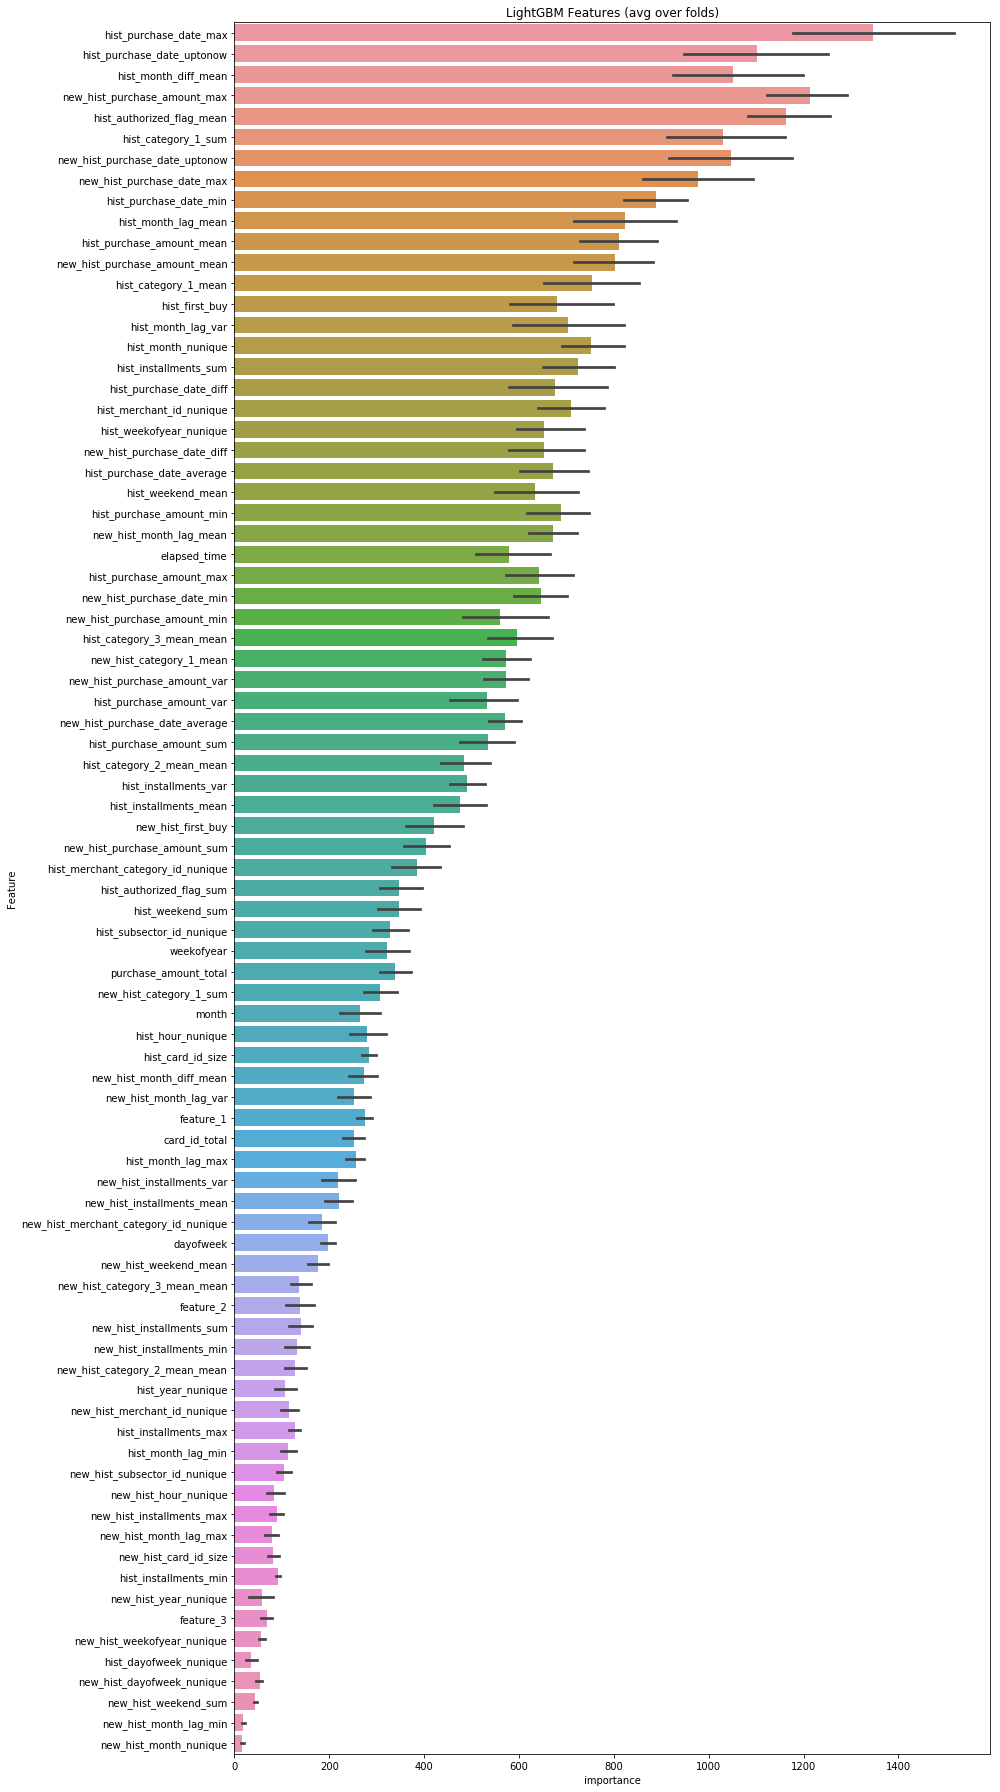

In [45]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
#plt.savefig('lgbm_importances_feature_eng_2_date_updated3.png')

In [49]:
target.shape

(201917,)

In [361]:
sub_df = pd.DataFrame({"card_id":df_test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("chau_feature_engineering_3_date_updated3.csv", index=False)

**To be continued ...**

In [243]:
best_features.groupby('Feature').mean().sort_values('importance',ascending=False).to_csv('feature_importance.csv')

In [159]:
df_train.to_csv('C:/Users/user/Documents/Salamat/ELO/train_new_lag_updated.csv',index=False)

In [160]:
df_test.to_csv('C:/Users/user/Documents/Salamat/ELO/test_new_lag_updated.csv',index=False)

In [88]:
best_features.groupby('Feature').mean().sort_values('importance',ascending=False).to_csv('best_features_dates.csv')

In [411]:
len(target[(target<=1)&(target>=-1)])/len(target)

0.5713040506742869

In [52]:
df_train.feature_1.unique()

array([ 0.01314462,  0.01071159,  0.01060989,  0.00805849,  0.01047939])

In [53]:
df_train.feature_2.unique()

array([ 0.00875212,  0.01138477,  0.0141664 ])

In [54]:
df_train.feature_3.unique()

array([ 0.01142752,  0.01028283])

In [70]:
from workalendar.america import Brazil
cal=Brazil()
for yr in [2011,2012]:
   print(yr,cal.holidays(yr))

2011 [(datetime.date(2011, 1, 1), 'New year'), (datetime.date(2011, 4, 21), "Tiradentes' Day"), (datetime.date(2011, 5, 1), 'Labour Day'), (datetime.date(2011, 9, 7), 'Independence Day'), (datetime.date(2011, 10, 12), 'Our Lady of Aparecida'), (datetime.date(2011, 11, 2), "All Souls' Day"), (datetime.date(2011, 11, 15), 'Republic Day'), (datetime.date(2011, 12, 25), 'Christmas Day')]
2012 [(datetime.date(2012, 1, 1), 'New year'), (datetime.date(2012, 4, 21), "Tiradentes' Day"), (datetime.date(2012, 5, 1), 'Labour Day'), (datetime.date(2012, 9, 7), 'Independence Day'), (datetime.date(2012, 10, 12), 'Our Lady of Aparecida'), (datetime.date(2012, 11, 2), "All Souls' Day"), (datetime.date(2012, 11, 15), 'Republic Day'), (datetime.date(2012, 12, 25), 'Christmas Day')]
